In [1]:
# Start writing code here...

In [7]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression



from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


In [8]:
RANDOM_SEED = 42

In [9]:
with open('train_test_dict.pickle', 'rb') as file:
        train_test_dict = pickle.load( file)
X_train_impute = train_test_dict['X_train_impute']
X_test_impute = train_test_dict['X_test_impute']
y_train = train_test_dict['y_train']
y_test = train_test_dict['y_test']

In [10]:
X_train_impute.shape

(3346, 79)

### Baseline
   - Distribution of the target and statistics such as mean and median 
   - It can be observed below that the target has a [left skewed distribution](https://stats.stackexchange.com/questions/11351/left-skewed-vs-symmetric-distribution-observed/11352#11352) with most well of the groundwater depth less that 200
   - The score of this regressor is very low : R-squared of the prediction = -0.057
   - The r-squared isnegative and this indicates that the the sum-of-squares of the residuals from the model (SSres) is larger than the sum-of-squares from the horizontal line (median) (SStot).
   - R-squared is computed as 1−SSres/SStot. (here, SSres = residual error)When SSres is greater than SStot, that equation could compute a negative value for R-squared, if the value of the coefficient is greater than 1.

In [14]:
def predict_score_base_regressors(reg, X, y, name_of_regressor:str):
    reg.fit(X,y)
    print(f"Prediction from {name_of_regressor} is : {reg.predict(X)}")
    print(f"Train Set Regression Score from {name_of_regressor} is : {reg.score(X,y)}")

In [15]:
dummy_regr = DummyRegressor(strategy="median")
lreg = LinearRegression()
rreg = Ridge()
lasreg = Lasso()

predict_score_base_regressors(dummy_regr, X_train_impute, y_train, "Dummy Regressor")
predict_score_base_regressors(lreg, X_train_impute, y_train, "Linear Regressor")
predict_score_base_regressors(rreg, X_train_impute, y_train, "Ridge Regressor")
predict_score_base_regressors(lasreg, X_train_impute, y_train, "Lasso Regressor")



Prediction from Dummy Regressor is : [135.47275 135.47275 135.47275 ... 135.47275 135.47275 135.47275]
Train Set Regression Score from Dummy Regressor is : -0.057090827770692965
Prediction from Linear Regressor is : [124.02559817 111.4254949   97.06014597 ... 324.66703306 320.78229306
 320.82513735]
Train Set Regression Score from Linear Regressor is : 0.5595387697659555
Prediction from Ridge Regressor is : [122.36096044 106.85415893  97.9512874  ... 315.23472464 310.35964295
 309.11776963]
Train Set Regression Score from Ridge Regressor is : 0.5116318808253719
Prediction from Lasso Regressor is : [100.4447834   83.95961512  79.61023103 ... 223.31467851 215.08817061
 214.40654012]
Train Set Regression Score from Lasso Regressor is : 0.3775917065499911


###  Generative versus Declarative algorithms

### Random searching to narrow down possibilities to provide to GridSearch

Regularization and Generalization for [Lasso](https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression)

When it comes to training models, there are two major problems one can encounter: overfitting and underfitting.

- Overfitting happens when the model performs well on the training set but not so well on unseen (test) data.
- Underfitting happens when it neither performs well on the train set nor on the test set.
Particularly, regularization is implemented to avoid overfitting of the data, especially when there is a large variance between train and test set performances. With regularization, the number of features used in training is kept constant, yet the magnitude of the coefficients is reduced.


**Ridge and Lasso** 

**Lasso Regression for Model Selection**
Lasso is short for Least Absolute Shrinkage and Selection Operator, which is used both for regularization and model selection. If a model uses the L1 regularization technique, then it is called lasso regression. 
Due to the fact that coefficients will be shrunk towards a mean of zero, less important features in a dataset are eliminated when penalized. The shrinkage of these coefficients based on the alpha value provided leads to some form of automatic feature selection, as input variables are removed in an effective approach.

**Ridge regression** puts a similar constraint on the coefficients by introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients, ridge regression takes the square.
Minimizes objective function:
||y - Xw||^2_2 + alpha * ||w||^2_2


**Scores**
[Negative Mean Absolute Error](https://stackoverflow.com/questions/55786121/what-is-the-negative-mean-absolute-error-in-scikit-learn#:~:text=As%20its%20name%20implies%2C%20negative,than%20a%20value%20of%20%2D3.0%20.) Smaller the better

In [16]:
rfreg = RandomForestRegressor(
    max_depth=2, n_estimators=200, random_state=RANDOM_SEED
).fit(X_train_impute, y_train)
print(f"Train set score: {rfreg.score(X_train_impute, y_train)}")
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
print(f"Test set score:{rfreg.score(X_test_impute, y_test)}") # without duration = -0.601225986040484

Train set score: 0.373097701276752
Test set score:-0.03730173138387993


In [17]:
# random search linear regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

model = Lasso()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_SEED)
# define search space
space = dict()

#space["solver"] = ["svd", "cholesky", "lsqr", "sag"]
#space["solver"] = ["svd"]
space["alpha"] =  [ 1,0.1,0.01,0.001,0.0001]    #loguniform(1e-5, 100)
space["fit_intercept"] = [True, False]
# define search
search = RandomizedSearchCV(
    model,
    space,
    n_iter= 100,  #500,
    scoring= 'r2',    #"neg_median_absolute_error",‘neg_root_mean_squared_error’
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_SEED,
)
# execute search
train_result = search.fit(X_train_impute, y_train)
# summarize result
print("Best Score: %s" % train_result.best_score_)
print("Best Hyperparameters: %s" % train_result.best_params_)


C:\Users\SimiTalkar\miniconda3\envs\pycaret_env\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.5351705218917426
Best Hyperparameters: {'fit_intercept': True, 'alpha': 0.001}


C:\Users\SimiTalkar\miniconda3\envs\pycaret_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1134283.8239211775, tolerance: 5521.090684564099
  model = cd_fast.enet_coordinate_descent(


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
alpha = 0.5
loop = 44
gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=loop, learning_rate=alpha, random_state=RANDOM_SEED, init="zero"
)
gbrt.fit(X_train_impute, y_train)
gbrt.loss
y_pred = gbrt.predict(X_test_impute)
r2GBRT = metrics.r2_score(y_test, y_pred)
print("GBT: R^2 = ", r2GBRT)


GBT: R^2 =  -0.43648030010048555


In [19]:
from  sklearn.svm import SVR



### Support Vector Machine Regressor

- We will be choosing the parameters first in this case and then run the regression with chosen parameters

In [12]:
## COmmenting out code since the best parameters have been found
# param_grid = [
#     {
#         "C": [0.5, 1, 10, 100],
#         "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
#         "kernel": ["rbf"],
#     }
# ]

# optimal_params = GridSearchCV(
#     SVR(),
#     param_grid,
#     cv=5,
#     scoring='r2',
#     verbose=0
# )
# optimal_params.fit(X_train_impute, y_train)
# print(optimal_params.best_params_)
#{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [20]:
svmreg = SVR(C= 100, gamma= 0.01, kernel= 'rbf')
svmreg.fit(X_train_impute, y_train)
print (f"Training Score : {svmreg.score(X_train_impute, y_train)}")
print (f"Testing Score : {svmreg.score(X_test_impute, y_test)}")


Training Score : 0.4618833343933595
Testing Score : 0.15005476507505677


In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
# params = {'n_neighbors':[20, 20, 50, 100, 300]}

# knn = KNeighborsRegressor()

# model = GridSearchCV(knn, params, cv=5)
# model.fit(X_train_impute,y_train)
# model.best_params_
#{'n_neighbors': 100}

In [23]:
knnreg = KNeighborsRegressor(n_neighbors=100)
knnreg.fit(X_train_impute, y_train)
print (f"Training Score : {knnreg.score(X_train_impute, y_train)}")
print (f"Testing Score : {knnreg.score(X_test_impute, y_test)}")

Training Score : 0.46663457919327955
Testing Score : 0.039350703259104836


#Ideas
1. Drop features such as vegetation and crops and soil
2. Add K Means clustering results

In [27]:
with open('X_train_impute_df.pkl', 'rb') as file:
        X_train_impute_df = pickle.load( file)


In [28]:
with open('X_test_impute_df.pkl', 'rb') as file:
        X_test_impute_df = pickle.load( file)

In [32]:
X_train_impute_df.shape

(3346, 79)

In [43]:
train_data = pd.concat([X_train_impute_df, y_train], axis=1)
test_data = pd.concat([X_test_impute_df, y_test], axis=1)


In [48]:
from pycaret.regression import *
#We already have an imputed and scaled train and test, we do not want to preprocess
water_depth_exp = setup(train_data, target='GSE_GWE',
                        train_size=1.0,
                        test_data= test_data,
                        preprocess=False, session_id=RANDOM_SEED,
                       log_experiment=True, experiment_name="water_depth_1")



,Description,Value
0,session_id,42
1,Target,GSE_GWE
2,Original Data,"(3346, 80)"
3,Missing Values,False
4,Numeric Features,79
5,Categorical Features,0
6,Transformed Train Set,"(3346, 79)"
7,Transformed Test Set,"(478, 79)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [51]:
%matplotlib inline
#creating a model
lr = create_model('lr')



,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,60.5388,5620.5918,74.9706,-1.5227,1.1444,2.5886
1,49.3387,5548.7603,74.4900,-0.6424,1.0168,1.8340
2,61.2456,5839.9990,76.4199,-0.6195,0.9926,1.6280
3,118.8062,28076.2383,167.5597,-0.1898,1.3896,1.0325
4,96.4245,14653.2568,121.0506,-0.1081,1.1343,4.7910
5,98.9647,17178.0098,131.0649,0.0658,0.8439,1.1027
6,59.3629,6646.0986,81.5236,0.5908,0.6764,0.4034
7,93.7905,14339.1016,119.7460,-0.7675,0.9613,0.4945
8,149.1625,33760.8281,183.7412,-0.2025,0.8881,1.1453


In [52]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,70.5179,10740.0180,97.2247,0.0540,0.7837,1.5393,0.2890
knn,K Neighbors Regressor,72.3936,11579.0293,102.3158,-0.0231,0.7836,1.3389,0.0250
lightgbm,Light Gradient Boosting Machine,72.2234,12082.0949,104.0247,-0.0865,0.7844,1.6298,0.0630
rf,Random Forest Regressor,73.4169,12195.5446,104.9810,-0.1185,0.7926,1.6145,0.4390
gbr,Gradient Boosting Regressor,76.1402,12038.4885,104.5773,-0.1513,0.8097,1.6620,0.1920
par,Passive Aggressive Regressor,82.9517,14187.0734,111.4536,-0.2351,0.8758,1.3517,0.0170
huber,Huber Regressor,82.1171,14566.4120,112.6090,-0.2532,0.8856,1.4366,0.0710
ridge,Ridge Regression,85.3541,14136.0790,112.3464,-0.2633,0.9009,1.6376,0.0140
lasso,Lasso Regression,87.8802,14246.0999,113.4517,-0.2746,0.9110,1.7799,0.2090
br,Bayesian Ridge,86.9092,14699.0325,115.0278,-0.3561,0.9327,1.6091,0.0170


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [53]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,53.0363,5126.2066,71.5975,-1.3008,1.1736,3.0000
1,30.0430,1500.0719,38.7308,0.5560,0.6725,1.0498
2,43.8292,2910.5393,53.9494,0.1929,0.8771,1.7781
3,94.2513,18941.7282,137.6290,0.1973,0.9518,1.1511
4,84.1569,13422.9810,115.8576,-0.0150,1.1178,5.0476
5,71.6312,13013.7122,114.0777,0.2923,0.6609,0.7204
6,52.9638,6682.1155,81.7442,0.5885,0.4385,0.3891
7,70.1110,8848.7840,94.0680,-0.0907,0.4725,0.4301
8,128.3566,26737.7562,163.5168,0.0477,0.7681,0.9291


In [55]:
tuned_et  = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,65.8685,5821.9516,76.3017,-1.6131,1.3439,3.8286
1,41.1770,2422.3424,49.2173,0.2830,0.8510,1.4975
2,58.2190,4772.3281,69.0820,-0.3234,1.0675,2.2995
3,120.0881,25542.1140,159.8190,-0.0824,1.0346,1.5344
4,81.4949,11210.6813,105.8805,0.1522,1.0396,3.4871
5,88.3400,15814.7677,125.7568,0.1400,0.7301,0.8500
6,80.1744,13682.3834,116.9717,0.1575,0.5901,0.5309
7,78.5067,9748.8373,98.7362,-0.2017,0.4742,0.3573
8,148.1815,35467.8366,188.3291,-0.2633,0.8458,0.9400


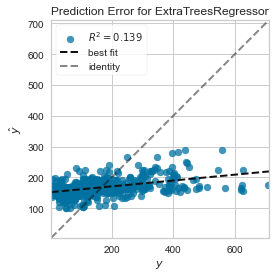

In [56]:
plot_model(tuned_et, plot = 'error')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>